### **Importing Libraries**


In [ ]:
#!pip install optuna

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew
#import optuna
import sklearn
import pickle
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Read & Understand Data**

In [2]:
train = pd.read_csv("/content/drive/My Drive/HackersEarth/train.csv")
train.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.961872,26.897875,NaN,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521
1,WM_698,2018-11-05 10:13:20,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.904078,39.801469,NaN,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275
2,WM_39146,2019-09-14 14:03:20,95.484724,NaN,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.927107,36.116065,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342
3,WM_6757,2018-12-25 15:33:20,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.732336,46.020045,44.827154,492.081520,1964.502895,42.744596,ABC,NaN,4.857385,0.367140,24.287767,14.851089
4,WM_21521,2019-05-04 03:13:20,10.722890,NaN,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.169007,34.572941,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,NaN,0.453374,27.971650,3.519074


In [3]:
test = pd.read_csv("/content/drive/My Drive/HackersEarth/test.csv")
test.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431
1,WM_18723,2019-03-30 07:43:20,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,NaN,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823
2,WM_34552,2019-08-10 11:33:20,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677
3,WM_28570,2019-06-26 03:53:20,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,NaN,23.886434,13.501595,NaN,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426
4,WM_36934,2019-08-27 16:43:20,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440


In [4]:
print("Train data contains % 2d rows and % 2d columns" %(train.shape[0],train.shape[1]), "\n")
print("Test data contains {} rows and {} columns" .format(test.shape[0],test.shape[1]))

Train data contains  28200 rows and  22 columns 

Test data contains 12086 rows and 21 columns


In [5]:
for columns in train.columns:
  if columns not in test.columns:
    print("Column not present in the Test Data is: ", columns)

Column not present in the Test Data is:  windmill_generated_power(kW/h)


### **EDA for Train Data**

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28200 entries, 0 to 28199
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tracking_id                     28200 non-null  object 
 1   datetime                        28200 non-null  object 
 2   wind_speed(m/s)                 27927 non-null  float64
 3   atmospheric_temperature(°C)     24750 non-null  float64
 4   shaft_temperature(°C)           28198 non-null  float64
 5   blades_angle(°)                 27984 non-null  float64
 6   gearbox_temperature(°C)         28199 non-null  float64
 7   engine_temperature(°C)          28188 non-null  float64
 8   motor_torque(N-m)               28176 non-null  float64
 9   generator_temperature(°C)       28188 non-null  float64
 10  atmospheric_pressure(Pascal)    25493 non-null  float64
 11  area_temperature(°C)            28200 non-null  float64
 12  windmill_body_temperature(°C)   

In [7]:
train.describe()

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
count,27927.000000,24750.000000,28198.000000,27984.000000,28199.000000,28188.000000,28176.000000,28188.000000,2.549300e+04,28200.000000,25837.000000,23097.000000,28199.000000,27628.000000,23107.000000,28200.000000,27657.000000,27993.000000
mean,69.037071,0.383727,40.085387,-9.654038,41.027755,42.614239,1710.819803,65.027857,5.318506e+04,32.735091,20.799761,306.888883,1575.560011,25.849894,2.254034,0.397249,25.887052,6.130529
std,76.275645,44.278534,27.204430,47.918161,43.663605,6.124546,827.205537,19.816499,1.875036e+05,7.703391,54.356431,134.055900,483.326394,32.423943,11.275602,0.061158,7.773609,2.697520
min,-496.211029,-99.000000,-99.000000,-146.259543,-244.974098,3.167151,500.000000,33.893779,-1.188624e+06,-30.000000,-999.000000,0.000000,-1005.222988,-136.732217,-99.000000,0.200111,-30.295253,0.962305
25%,20.883502,7.948900,41.633238,-1.197652,40.557952,41.911365,870.340239,41.198509,1.679492e+04,27.311644,40.448386,238.627752,1268.134043,13.722808,2.544859,0.347445,24.447658,4.059505
50%,93.302129,16.102410,43.686082,-0.495608,43.221735,43.525297,2031.849540,70.729533,1.819113e+04,32.605195,42.786832,271.427656,1678.238404,32.977192,3.453333,0.398591,25.957739,5.764710
75%,95.268058,23.687285,45.673685,5.495030,45.879425,45.174246,2462.585729,78.945849,1.181133e+05,38.232387,44.494543,404.153517,1829.054007,41.550520,4.357862,0.449354,27.477854,7.947195
max,601.455670,80.217444,169.820455,165.932123,999.000000,50.000000,3000.000000,100.000000,1.272552e+06,55.000000,323.000000,569.966479,4693.481933,236.883264,18.209800,0.499975,78.351335,20.175358


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efbc89c2510>,
      dtype=object)

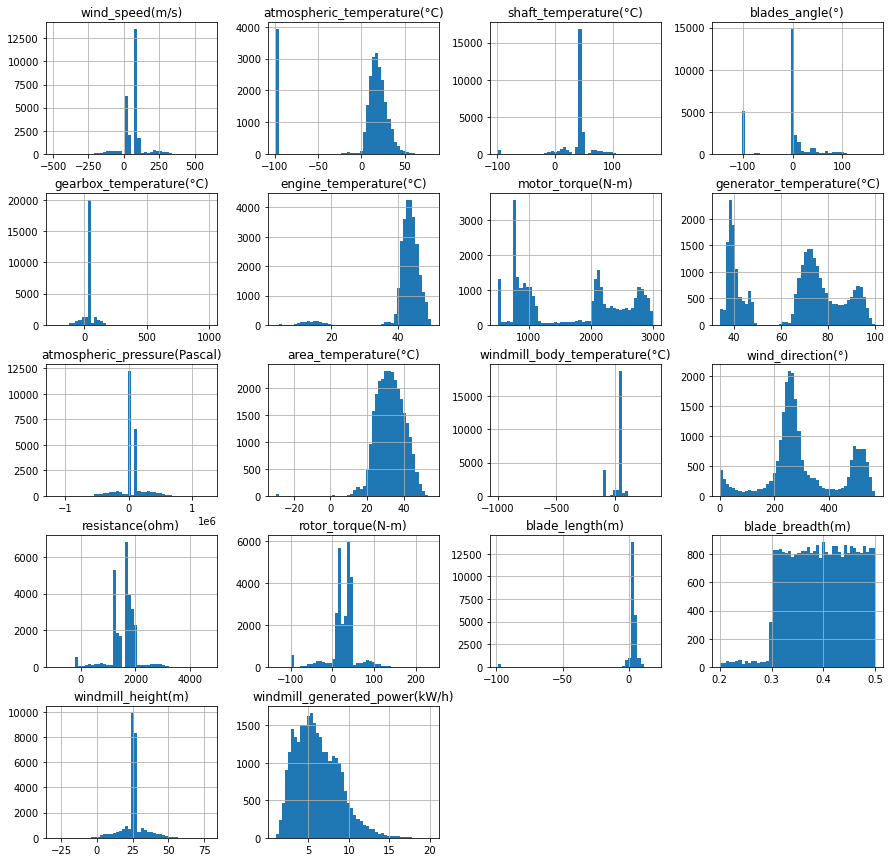

In [8]:
train.hist(bins=50, figsize=(15, 15))

In [9]:
train.skew()

wind_speed(m/s)                  -0.060477
atmospheric_temperature(°C)      -1.674895
shaft_temperature(°C)            -2.525168
blades_angle(°)                  -0.652122
gearbox_temperature(°C)           0.886846
engine_temperature(°C)           -3.944776
motor_torque(N-m)                 0.034258
generator_temperature(°C)        -0.190809
atmospheric_pressure(Pascal)      0.056671
area_temperature(°C)             -0.625424
windmill_body_temperature(°C)    -2.236832
wind_direction(°)                 0.171942
resistance(ohm)                  -0.697809
rotor_torque(N-m)                -1.030947
blade_length(m)                  -8.608358
blade_breadth(m)                 -0.193401
windmill_height(m)               -0.113280
windmill_generated_power(kW/h)    0.688935
dtype: float64

In [10]:
#print(data_train.isnull().any())
print(train.isnull().sum())

tracking_id                          0
datetime                             0
wind_speed(m/s)                    273
atmospheric_temperature(°C)       3450
shaft_temperature(°C)                2
blades_angle(°)                    216
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2707
area_temperature(°C)                 0
windmill_body_temperature(°C)     2363
wind_direction(°)                 5103
resistance(ohm)                      1
rotor_torque(N-m)                  572
turbine_status                    1759
cloud_level                        276
blade_length(m)                   5093
blade_breadth(m)                     0
windmill_height(m)                 543
windmill_generated_power(kW/h)     207
dtype: int64


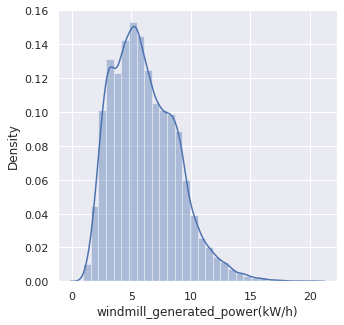

In [11]:
sns.set(rc={'figure.figsize':(5,5)})
sns.distplot(train['windmill_generated_power(kW/h)'], bins=30)
plt.show()

### **EDA for Test Data**

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12086 entries, 0 to 12085
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tracking_id                    12086 non-null  object 
 1   datetime                       12086 non-null  object 
 2   wind_speed(m/s)                11960 non-null  float64
 3   atmospheric_temperature(°C)    10659 non-null  float64
 4   shaft_temperature(°C)          12085 non-null  float64
 5   blades_angle(°)                11980 non-null  float64
 6   gearbox_temperature(°C)        12085 non-null  float64
 7   engine_temperature(°C)         12081 non-null  float64
 8   motor_torque(N-m)              12075 non-null  float64
 9   generator_temperature(°C)      12081 non-null  float64
 10  atmospheric_pressure(Pascal)   10935 non-null  float64
 11  area_temperature(°C)           12085 non-null  float64
 12  windmill_body_temperature(°C)  11160 non-null 

In [13]:
test.describe()

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),blade_length(m),blade_breadth(m),windmill_height(m)
count,11960.000000,10659.000000,12085.000000,11980.000000,12085.000000,12081.000000,12075.000000,12081.000000,1.093500e+04,12085.000000,11160.000000,9926.000000,12086.000000,11805.000000,9972.000000,12086.000000,11831.000000
mean,69.381862,0.687445,39.936571,-9.218509,40.318639,42.604738,1717.343991,65.237894,5.428332e+04,32.796168,20.906469,308.376140,1581.289398,26.566581,2.201328,0.397527,25.963743
std,76.119487,44.051104,27.114499,47.574365,42.481822,6.215124,829.809203,19.868135,1.872562e+05,7.671919,53.291337,133.923293,483.125121,32.103827,11.513251,0.061661,7.716063
min,-525.530600,-99.000000,-99.000000,-99.000000,-185.860883,-5.000000,500.000000,30.000000,-1.207259e+06,-30.000000,-99.000000,0.000000,-1654.449587,-182.169613,-99.000000,0.200009,-21.215639
25%,21.809823,8.118199,41.635406,-1.191777,40.460379,41.925716,874.238660,41.283334,1.679650e+04,27.406656,40.366937,238.782318,1272.310773,13.760163,2.520990,0.346909,24.452970
50%,93.338083,16.177184,43.707769,-0.497108,43.219752,43.553196,2032.285162,70.797759,1.820142e+04,32.658467,42.788389,272.047526,1680.225602,33.090562,3.434327,0.399637,25.950314
75%,95.251808,23.855116,45.756032,6.232264,45.840152,45.228475,2480.423058,79.432294,1.183212e+05,38.302814,44.506596,408.668722,1837.302026,41.976934,4.342784,0.450488,27.490102
max,525.434211,80.442232,183.299983,170.047823,563.000000,49.858945,2997.013769,99.571599,1.127571e+06,53.927698,191.979747,570.857751,4106.196001,213.260076,17.847936,0.499985,77.604969


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efbc607afd0>,
      dtype=object)

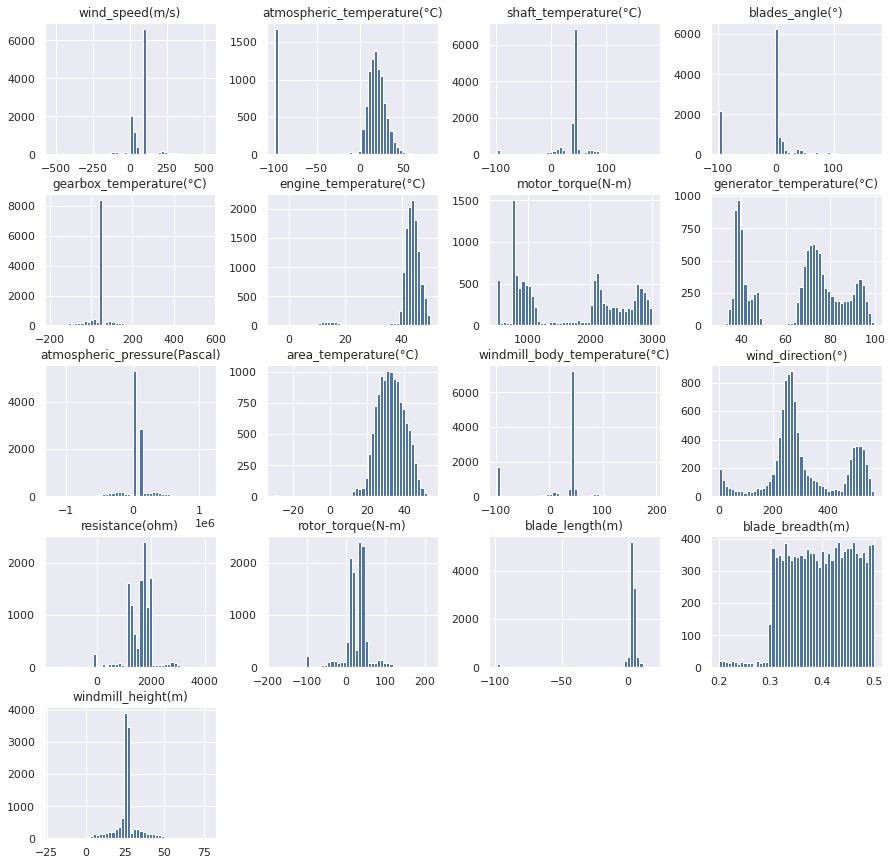

In [14]:
test.hist(bins=50, figsize=(15, 15))

In [15]:
test.skew()

wind_speed(m/s)                 -0.186603
atmospheric_temperature(°C)     -1.691742
shaft_temperature(°C)           -2.586815
blades_angle(°)                 -0.676513
gearbox_temperature(°C)         -0.183242
engine_temperature(°C)          -3.874864
motor_torque(N-m)                0.031105
generator_temperature(°C)       -0.193475
atmospheric_pressure(Pascal)     0.068360
area_temperature(°C)            -0.539537
windmill_body_temperature(°C)   -1.570474
wind_direction(°)                0.169702
resistance(ohm)                 -0.752013
rotor_torque(N-m)               -0.907148
blade_length(m)                 -8.436438
blade_breadth(m)                -0.219657
windmill_height(m)               0.022495
dtype: float64

In [16]:
#print(data_train.isnull().any())
print(test.isnull().sum())

tracking_id                         0
datetime                            0
wind_speed(m/s)                   126
atmospheric_temperature(°C)      1427
shaft_temperature(°C)               1
blades_angle(°)                   106
gearbox_temperature(°C)             1
engine_temperature(°C)              5
motor_torque(N-m)                  11
generator_temperature(°C)           5
atmospheric_pressure(Pascal)     1151
area_temperature(°C)                1
windmill_body_temperature(°C)     926
wind_direction(°)                2160
resistance(ohm)                     0
rotor_torque(N-m)                 281
turbine_status                    797
cloud_level                       125
blade_length(m)                  2114
blade_breadth(m)                    0
windmill_height(m)                255
dtype: int64


### **Identifying the Numerical and Categorical Columns**

In [17]:
data_train = train.copy()
data_test = test.copy()

In [18]:
categoricalData = [column for column in data_train.columns if data_train[column].dtype == object ]
print("Categorical Columns in Train data are: ", categoricalData)

numericalData  = [column for column in data_train.columns if data_train[column].dtype != object]
print("Numerical Columns in Train data are: ", numericalData)

numericalDataTest  = [column for column in data_test.columns if data_test[column].dtype != object]
print("Numerical Columns in Test data are: ", numericalDataTest)

Categorical Columns in Train data are:  ['tracking_id', 'datetime', 'turbine_status', 'cloud_level']
Numerical Columns in Train data are:  ['wind_speed(m/s)', 'atmospheric_temperature(°C)', 'shaft_temperature(°C)', 'blades_angle(°)', 'gearbox_temperature(°C)', 'engine_temperature(°C)', 'motor_torque(N-m)', 'generator_temperature(°C)', 'atmospheric_pressure(Pascal)', 'area_temperature(°C)', 'windmill_body_temperature(°C)', 'wind_direction(°)', 'resistance(ohm)', 'rotor_torque(N-m)', 'blade_length(m)', 'blade_breadth(m)', 'windmill_height(m)', 'windmill_generated_power(kW/h)']
Numerical Columns in Test data are:  ['wind_speed(m/s)', 'atmospheric_temperature(°C)', 'shaft_temperature(°C)', 'blades_angle(°)', 'gearbox_temperature(°C)', 'engine_temperature(°C)', 'motor_torque(N-m)', 'generator_temperature(°C)', 'atmospheric_pressure(Pascal)', 'area_temperature(°C)', 'windmill_body_temperature(°C)', 'wind_direction(°)', 'resistance(ohm)', 'rotor_torque(N-m)', 'blade_length(m)', 'blade_breadth

### **Cleaning Data**

#### **Removing negative values from Data**

In [20]:
print(data_train[(data_train['wind_speed(m/s)'] < 0 )].shape)
print(data_train[(data_train['blade_length(m)'] < 0 )].shape)
print(data_train[(data_train['blade_breadth(m)'] < 0 )].shape)
print(data_train[(data_train['windmill_height(m)'] < 0 )].shape)
print('--------------Test------------------')
print(data_test[(data_test['wind_speed(m/s)'] < 0 )].shape)
print(data_test[(data_test['blade_length(m)'] < 0 )].shape)
print(data_test[(data_test['blade_breadth(m)'] < 0 )].shape)
print(data_test[(data_test['windmill_height(m)'] < 0 )].shape)

(2142, 22)
(1441, 22)
(0, 22)
(149, 22)
--------------Test------------------
(866, 21)
(602, 21)
(0, 21)
(52, 21)


In [21]:
data_train['wind_speed(m/s)'] = np.absolute(data_train['wind_speed(m/s)'])
data_train['blade_length(m)'] = np.absolute(data_train['blade_length(m)'])
data_train['windmill_height(m)'] = np.absolute(data_train['blade_length(m)'])
data_test['wind_speed(m/s)'] = np.absolute(data_test['wind_speed(m/s)'])
data_test['blade_length(m)'] = np.absolute(data_test['blade_length(m)'])
data_test['windmill_height(m)'] = np.absolute(data_test['blade_length(m)'])

In [22]:
for column in numericalData:
  Q1,Q3 = np.nanpercentile(data_train[column] , [25,75])
  IQR = Q3 - Q1
  cutOff = 1.5 * IQR
  lower_range = Q1 - cutOff
  upper_range = Q3 + cutOff
  print("Column is {} Q1 Value is {} Q3 value is {} lower bound is {} and upper bound is {}".format(column,Q1,Q3,lower_range,upper_range))

Column is wind_speed(m/s) Q1 Value is 34.136047564866296 Q3 value is 95.61157538981371 lower bound is -58.07724417255482 and upper bound is 187.82486712723482
Column is atmospheric_temperature(°C) Q1 Value is 7.948900130778931 Q3 value is 23.68728525013317 lower bound is -15.658677548252427 and upper bound is 47.29486292916452
Column is shaft_temperature(°C) Q1 Value is 41.63323757336114 Q3 value is 45.673685389506474 lower bound is 35.572565849143146 and upper bound is 51.73435711372447
Column is blades_angle(°) Q1 Value is -1.197651598714835 Q3 value is 5.495030481379197 lower bound is -11.236674718855884 and upper bound is 15.534053601520245
Column is gearbox_temperature(°C) Q1 Value is 40.55795190456007 Q3 value is 45.87942476117522 lower bound is 32.57574261963734 and upper bound is 53.86163404609795
Column is engine_temperature(°C) Q1 Value is 41.91136469650659 Q3 value is 45.17424573852502 lower bound is 37.017043133478936 and upper bound is 50.068567301552676
Column is motor_to

In [23]:
for column in numericalDataTest:
  Q1,Q3 = np.nanpercentile(data_test[column] , [25,75])
  IQR = Q3 - Q1
  cutOff = 1.5 * IQR
  lower_range = Q1 - cutOff
  upper_range = Q3 + cutOff
  print("Column is {} Q1 Value is {} Q3 value is {} lower bound is {} and upper bound is {}".format(column,Q1,Q3,lower_range,upper_range))

Column is wind_speed(m/s) Q1 Value is 34.646596348253766 Q3 value is 95.57270919301662 lower bound is -56.74257291889052 and upper bound is 186.9618784601609
Column is atmospheric_temperature(°C) Q1 Value is 8.11819894857878 Q3 value is 23.855115697433323 lower bound is -15.487176174703038 and upper bound is 47.46049082071514
Column is shaft_temperature(°C) Q1 Value is 41.635405633682204 Q3 value is 45.75603200312712 lower bound is 35.45446607951483 and upper bound is 51.936971557294484
Column is blades_angle(°) Q1 Value is -1.1917765504166449 Q3 value is 6.23226353220702 lower bound is -12.327836674352142 and upper bound is 17.36832365614252
Column is gearbox_temperature(°C) Q1 Value is 40.460378818964394 Q3 value is 45.840152150933505 lower bound is 32.39071882101072 and upper bound is 53.90981214888717
Column is engine_temperature(°C) Q1 Value is 41.92571630560124 Q3 value is 45.2284753566214 lower bound is 36.971577729071 and upper bound is 50.18261393315164
Column is motor_torque(

#### **Handling outliers**

In [24]:
data_train.loc[data_train['wind_speed(m/s)'] > 186, ['wind_speed(m/s)']] = (34+96)/2
data_test.loc[data_test['wind_speed(m/s)'] > 186, ['wind_speed(m/s)']] = (34+96)/2

In [25]:
print(data_train[(data_train['blade_length(m)'] > 7)].shape)
data_train.loc[data_train['blade_length(m)'] > 7, ['blade_length(m)']] = (2+3)/2

print(data_test[(data_test['blade_length(m)'] > 7)].shape)
data_test.loc[data_test['blade_length(m)'] > 7, ['blade_length(m)']] = (2+3)/2

(1405, 22)
(628, 21)


In [26]:
print(data_train[(data_train['area_temperature(°C)'] < 11)].shape)
data_train.loc[data_train['area_temperature(°C)'] < 11 , ['area_temperature(°C)']] = (27+38)/2

print(data_test[(data_test['area_temperature(°C)'] < 11)].shape)
data_test.loc[data_test['area_temperature(°C)'] < 11 , ['area_temperature(°C)']] = (27+38)/2

(71, 22)
(30, 21)


In [27]:
print(data_train[(data_train['engine_temperature(°C)'] < 38)].shape)
data_train.loc[data_train['engine_temperature(°C)'] < 11 , ['engine_temperature(°C)']] = (42+45)/2

print(data_test[(data_test['engine_temperature(°C)'] < 38)].shape)
data_test.loc[data_test['engine_temperature(°C)'] < 11 , ['engine_temperature(°C)']] = (42+45)/2

(1303, 22)
(572, 21)


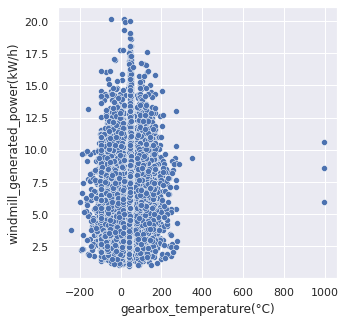

In [28]:
sns.scatterplot(x='gearbox_temperature(°C)',y='windmill_generated_power(kW/h)',data=data_train)

In [29]:
print(data_train[(data_train['gearbox_temperature(°C)'] < -200)].shape)
print(data_train[(data_train['gearbox_temperature(°C)'] > 300)].shape)
data_train.loc[(data_train['gearbox_temperature(°C)'] < -200) | (data_train['gearbox_temperature(°C)'] > 300) , ['gearbox_temperature(°C)']] = data_train['gearbox_temperature(°C)'].mean()

(2, 22)
(4, 22)


In [30]:
print(data_test[(data_test['gearbox_temperature(°C)'] < -200)].shape)
print(data_test[(data_test['gearbox_temperature(°C)'] > 300)].shape)
data_test.loc[(data_test['gearbox_temperature(°C)'] < -200) | (data_test['gearbox_temperature(°C)'] > 300) , ['gearbox_temperature(°C)']] = data_test['gearbox_temperature(°C)'].mean()

(0, 21)
(1, 21)


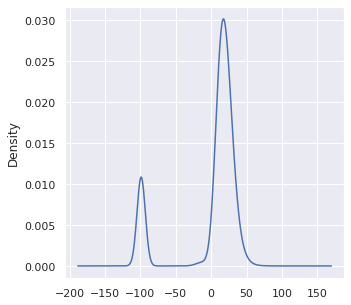

In [31]:
data_train['atmospheric_temperature(°C)'].plot(kind='kde')

In [32]:
print(data_train[(data_train['atmospheric_temperature(°C)'] < -50)].shape)
 #df['atmospheric_temperature(°C)'].mean()
print(data_test[(data_test['atmospheric_temperature(°C)'] < -50)].shape)
 #df['atmospheric_temperature(°C)'].mean()

(3943, 22)
(1672, 21)


### **Handling Null Values in Numerical data**

In [33]:
for column in numericalData:
  if column == 'windmill_generated_power(kW/h)':
    continue
  else:
    data_train[column] = data_train[column].fillna(data_train[column].mean())
  
data_train.isnull().sum()

tracking_id                          0
datetime                             0
wind_speed(m/s)                      0
atmospheric_temperature(°C)          0
shaft_temperature(°C)                0
blades_angle(°)                      0
gearbox_temperature(°C)              0
engine_temperature(°C)               0
motor_torque(N-m)                    0
generator_temperature(°C)            0
atmospheric_pressure(Pascal)         0
area_temperature(°C)                 0
windmill_body_temperature(°C)        0
wind_direction(°)                    0
resistance(ohm)                      0
rotor_torque(N-m)                    0
turbine_status                    1759
cloud_level                        276
blade_length(m)                      0
blade_breadth(m)                     0
windmill_height(m)                   0
windmill_generated_power(kW/h)     207
dtype: int64

In [34]:
for column in numericalDataTest:
  data_test[column] = data_test[column].fillna(data_test[column].mean())
  
data_test.isnull().sum()

tracking_id                        0
datetime                           0
wind_speed(m/s)                    0
atmospheric_temperature(°C)        0
shaft_temperature(°C)              0
blades_angle(°)                    0
gearbox_temperature(°C)            0
engine_temperature(°C)             0
motor_torque(N-m)                  0
generator_temperature(°C)          0
atmospheric_pressure(Pascal)       0
area_temperature(°C)               0
windmill_body_temperature(°C)      0
wind_direction(°)                  0
resistance(ohm)                    0
rotor_torque(N-m)                  0
turbine_status                   797
cloud_level                      125
blade_length(m)                    0
blade_breadth(m)                   0
windmill_height(m)                 0
dtype: int64

### **Handling Null Values in Categorical Data**

##### **Finding unique value for the categorical columns**

In [35]:
for col in categoricalData:
  if not (col == 'tracking_id') and not (col == 'datetime'):
    print("Unique values for: ", col)
    print(data_train[col].unique())
    print("\n")

Unique values for:  turbine_status
['BA' 'A2' 'ABC' 'AAA' 'BD' 'AC' 'BB' 'BCB' 'B' 'AB' nan 'B2' 'BBB' 'A'
 'D']


Unique values for:  cloud_level
['Medium' nan 'Low' 'Extremely Low']




In [36]:
print('Total null values in Cloud Level Feature: {}'.format(data_train['cloud_level'].isnull().sum()))
print('Total null values in Turnbine Status Feature: {}'.format(data_train['turbine_status'].isnull().sum()))

Total null values in Cloud Level Feature: 276
Total null values in Turnbine Status Feature: 1759


In [37]:
for col in categoricalData:
  if not (col == 'tracking_id') and not (col == 'datetime'):
    print("Unique values for: ", col)
    print(data_test[col].unique())
    print("\n")

Unique values for:  turbine_status
['BA' 'A' 'B2' 'BBB' 'BB' 'AAA' 'BCB' 'B' nan 'D' 'ABC' 'AB' 'BD' 'A2'
 'AC']


Unique values for:  cloud_level
['Medium' 'Low' nan 'Extremely Low']




##### **Replace Null values with MODE**

In [38]:
for column in categoricalData:
  if column == 'tracking_id' or column == 'datetime':
    continue;
  else:
    modeValue = data_train[column].mode()[0]
    print('Mode for {} is: {}'.format(column, modeValue), "\n")
    data_train[column] = data_train[column].fillna(modeValue)
    

data_train.isnull().sum()

Mode for turbine_status is: BB 

Mode for cloud_level is: Low 



tracking_id                         0
datetime                            0
wind_speed(m/s)                     0
atmospheric_temperature(°C)         0
shaft_temperature(°C)               0
blades_angle(°)                     0
gearbox_temperature(°C)             0
engine_temperature(°C)              0
motor_torque(N-m)                   0
generator_temperature(°C)           0
atmospheric_pressure(Pascal)        0
area_temperature(°C)                0
windmill_body_temperature(°C)       0
wind_direction(°)                   0
resistance(ohm)                     0
rotor_torque(N-m)                   0
turbine_status                      0
cloud_level                         0
blade_length(m)                     0
blade_breadth(m)                    0
windmill_height(m)                  0
windmill_generated_power(kW/h)    207
dtype: int64

In [39]:
for column in categoricalData:
  if column == 'tracking_id' or column == 'datetime':
    continue;
  else:
    modeValue = data_test[column].mode()[0]
    print('Mode for {} is: {}'.format(column, modeValue), "\n")
    data_test[column] = data_test[column].fillna(modeValue)
    

data_test.isnull().sum()

Mode for turbine_status is: BB 

Mode for cloud_level is: Low 



tracking_id                      0
datetime                         0
wind_speed(m/s)                  0
atmospheric_temperature(°C)      0
shaft_temperature(°C)            0
blades_angle(°)                  0
gearbox_temperature(°C)          0
engine_temperature(°C)           0
motor_torque(N-m)                0
generator_temperature(°C)        0
atmospheric_pressure(Pascal)     0
area_temperature(°C)             0
windmill_body_temperature(°C)    0
wind_direction(°)                0
resistance(ohm)                  0
rotor_torque(N-m)                0
turbine_status                   0
cloud_level                      0
blade_length(m)                  0
blade_breadth(m)                 0
windmill_height(m)               0
dtype: int64

### **Converting Categorical Data to Numerical Data**

In [40]:
data_train = pd.get_dummies(data_train, columns=['turbine_status','cloud_level'])
data_train.head(1)

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h),turbine_status_A,turbine_status_A2,turbine_status_AAA,turbine_status_AB,turbine_status_ABC,turbine_status_AC,turbine_status_B,turbine_status_B2,turbine_status_BA,turbine_status_BB,turbine_status_BBB,turbine_status_BCB,turbine_status_BD,turbine_status_D,cloud_level_Extremely Low,cloud_level_Low,cloud_level_Medium
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.0,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.66556,103402.961872,26.897875,20.799761,239.836388,2730.310605,42.084666,2.217542,0.314065,2.217542,6.766521,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [41]:
data_test = pd.get_dummies(data_test, columns=['turbine_status','cloud_level'])
data_test.head(1)

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_A,turbine_status_A2,turbine_status_AAA,turbine_status_AB,turbine_status_ABC,turbine_status_AC,turbine_status_B,turbine_status_B2,turbine_status_BA,turbine_status_BB,turbine_status_BBB,turbine_status_BCB,turbine_status_BD,turbine_status_D,cloud_level_Extremely Low,cloud_level_Low,cloud_level_Medium
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.46056,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,3.185837,0.403965,3.185837,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


### **Converting date to datetime format splitting its value according to Date, Day and year**



In [42]:
data_train['datetimeNew'] = pd.to_datetime(data_train['datetime'])
data_train['month'] = data_train['datetimeNew'].dt.month
data_train['day'] = data_train['datetimeNew'].dt.day
data_train['year'] = data_train['datetimeNew'].dt.year
data_train['hour'] = data_train['datetimeNew'].dt.hour
data_train['minute'] = data_train['datetimeNew'].dt.minute
data_train.drop(['datetimeNew'], axis=1, inplace= True)
data_train.head(1)

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h),turbine_status_A,turbine_status_A2,turbine_status_AAA,turbine_status_AB,turbine_status_ABC,turbine_status_AC,turbine_status_B,turbine_status_B2,turbine_status_BA,turbine_status_BB,turbine_status_BBB,turbine_status_BCB,turbine_status_BD,turbine_status_D,cloud_level_Extremely Low,cloud_level_Low,cloud_level_Medium,month,day,year,hour,minute
0,WM_33725,2019-08-04 14:33:20,94.820023,-99.0,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.66556,103402.961872,26.897875,20.799761,239.836388,2730.310605,42.084666,2.217542,0.314065,2.217542,6.766521,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,8,4,2019,14,33


In [43]:
data_test['datetimeNew'] = pd.to_datetime(data_test['datetime'])
data_test['month'] = data_test['datetimeNew'].dt.month
data_test['day'] = data_test['datetimeNew'].dt.day
data_test['year'] = data_test['datetimeNew'].dt.year
data_test['hour'] = data_test['datetimeNew'].dt.hour
data_test['minute'] = data_test['datetimeNew'].dt.minute
data_test.drop(['datetimeNew'], axis=1, inplace= True)
data_test.head(1)

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_A,turbine_status_A2,turbine_status_AAA,turbine_status_AB,turbine_status_ABC,turbine_status_AC,turbine_status_B,turbine_status_B2,turbine_status_BA,turbine_status_BB,turbine_status_BBB,turbine_status_BCB,turbine_status_BD,turbine_status_D,cloud_level_Extremely Low,cloud_level_Low,cloud_level_Medium,month,day,year,hour,minute
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.46056,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,3.185837,0.403965,3.185837,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,4,17,2019,8,53


### **z-score**

In [44]:
for column in numericalData:
  z_score_Count = data_train[(np.abs(stats.zscore(data_train[column])) < 3)].shape
  print("Column: ", column,"\t\t", "Z-score: ", z_score_Count)

Column:  wind_speed(m/s) 		 Z-score:  (28129, 42)
Column:  atmospheric_temperature(°C) 		 Z-score:  (28200, 42)
Column:  shaft_temperature(°C) 		 Z-score:  (27560, 42)
Column:  blades_angle(°) 		 Z-score:  (28185, 42)
Column:  gearbox_temperature(°C) 		 Z-score:  (27593, 42)
Column:  engine_temperature(°C) 		 Z-score:  (27309, 42)
Column:  motor_torque(N-m) 		 Z-score:  (28200, 42)
Column:  generator_temperature(°C) 		 Z-score:  (28200, 42)
Column:  atmospheric_pressure(Pascal) 		 Z-score:  (27604, 42)
Column:  area_temperature(°C) 		 Z-score:  (28198, 42)
Column:  windmill_body_temperature(°C) 		 Z-score:  (28196, 42)
Column:  wind_direction(°) 		 Z-score:  (28200, 42)
Column:  resistance(ohm) 		 Z-score:  (27372, 42)
Column:  rotor_torque(N-m) 		 Z-score:  (27446, 42)
Column:  blade_length(m) 		 Z-score:  (27821, 42)
Column:  blade_breadth(m) 		 Z-score:  (28129, 42)
Column:  windmill_height(m) 		 Z-score:  (27925, 42)
Column:  windmill_generated_power(kW/h) 		 Z-score:  (0, 42)


In [45]:
for column in numericalDataTest:
  z_score_Count = data_test[(np.abs(stats.zscore(data_test[column])) < 3)].shape
  print("Column: ", column,"\t\t", "Z-score: ", z_score_Count)

Column:  wind_speed(m/s) 		 Z-score:  (12053, 41)
Column:  atmospheric_temperature(°C) 		 Z-score:  (12086, 41)
Column:  shaft_temperature(°C) 		 Z-score:  (11815, 41)
Column:  blades_angle(°) 		 Z-score:  (12080, 41)
Column:  gearbox_temperature(°C) 		 Z-score:  (11823, 41)
Column:  engine_temperature(°C) 		 Z-score:  (11676, 41)
Column:  motor_torque(N-m) 		 Z-score:  (12086, 41)
Column:  generator_temperature(°C) 		 Z-score:  (12086, 41)
Column:  atmospheric_pressure(Pascal) 		 Z-score:  (11842, 41)
Column:  area_temperature(°C) 		 Z-score:  (12086, 41)
Column:  windmill_body_temperature(°C) 		 Z-score:  (12085, 41)
Column:  wind_direction(°) 		 Z-score:  (12086, 41)
Column:  resistance(ohm) 		 Z-score:  (11726, 41)
Column:  rotor_torque(N-m) 		 Z-score:  (11772, 41)
Column:  blade_length(m) 		 Z-score:  (11930, 41)
Column:  blade_breadth(m) 		 Z-score:  (12046, 41)
Column:  windmill_height(m) 		 Z-score:  (11962, 41)


In [46]:
# df.loc[(np.abs(stats.zscore(df['atmospheric_pressure(Pascal)']))) > 3, ['atmospheric_pressure(Pascal)']] = df['atmospheric_pressure(Pascal)'].mean()
# df.loc[(np.abs(stats.zscore(df['atmospheric_pressure(Pascal)']))) > 3].shape

In [47]:
zscoreCol = ['engine_temperature(°C)', 'shaft_temperature(°C)', 'atmospheric_pressure(Pascal)', 'resistance(ohm)', 'rotor_torque(N-m)','blade_length(m)', 'windmill_height(m)']
for column in zscoreCol:
  data_train.loc[(np.abs(stats.zscore(data_train[column]))) > 3, [column]] = data_train[column].mean()
  print("Column: ", column, "Shape: ", data_train.loc[(np.abs(stats.zscore(data_train[column]))) > 3].shape)

for column in zscoreCol:
  data_test.loc[(np.abs(stats.zscore(data_test[column]))) > 3, [column]] = data_test[column].mean()
  print("Column: ", column, "Shape: ", data_test.loc[(np.abs(stats.zscore(data_test[column]))) > 3].shape)

Column:  engine_temperature(°C) Shape:  (137, 42)
Column:  shaft_temperature(°C) Shape:  (505, 42)
Column:  atmospheric_pressure(Pascal) Shape:  (743, 42)
Column:  resistance(ohm) Shape:  (692, 42)
Column:  rotor_torque(N-m) Shape:  (693, 42)
Column:  blade_length(m) Shape:  (258, 42)
Column:  windmill_height(m) Shape:  (458, 42)
Column:  engine_temperature(°C) Shape:  (63, 41)
Column:  shaft_temperature(°C) Shape:  (220, 41)
Column:  atmospheric_pressure(Pascal) Shape:  (318, 41)
Column:  resistance(ohm) Shape:  (294, 41)
Column:  rotor_torque(N-m) Shape:  (283, 41)
Column:  blade_length(m) Shape:  (109, 41)
Column:  windmill_height(m) Shape:  (204, 41)


### **Handling Skewness of the Data**

In [48]:
skewedColumns = ['wind_speed(m/s)','atmospheric_temperature(°C)', 'shaft_temperature(°C)', 'engine_temperature(°C)', 'windmill_body_temperature(°C)', 'rotor_torque(N-m)', 'blade_length(m)']
power = PowerTransformer(method='yeo-johnson', standardize=True) 
for column in skewedColumns:
  columnDetail = data_train[column].values.reshape(-1,1)
  data_train[column] = power.fit_transform(columnDetail)

data_train.head(2)

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h),turbine_status_A,turbine_status_A2,turbine_status_AAA,turbine_status_AB,turbine_status_ABC,turbine_status_AC,turbine_status_B,turbine_status_B2,turbine_status_BA,turbine_status_BB,turbine_status_BBB,turbine_status_BCB,turbine_status_BD,turbine_status_D,cloud_level_Extremely Low,cloud_level_Low,cloud_level_Medium,month,day,year,hour,minute
0,WM_33725,2019-08-04 14:33:20,0.651129,-1.663591,-0.090728,-0.903423,82.410573,-0.514308,2563.124522,76.665560,103402.961872,26.897875,-0.546561,239.836388,2730.310605,0.553084,-1.117741,0.314065,2.217542,6.766521,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,8,4,2019,14,33
1,WM_698,2018-11-05 10:13:20,-0.168574,1.029321,-0.184357,-99.000000,44.104919,1.137362,2372.384119,78.129803,17030.904078,39.801469,-0.546561,337.944723,1780.207200,3.676091,0.928588,0.448494,4.210346,5.966275,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,11,5,2018,10,13


In [49]:
skewedColumns = ['wind_speed(m/s)','atmospheric_temperature(°C)', 'shaft_temperature(°C)', 'engine_temperature(°C)', 'windmill_body_temperature(°C)', 'rotor_torque(N-m)', 'blade_length(m)']
power = PowerTransformer(method='yeo-johnson', standardize=True) 
for column in skewedColumns:
  columnDetail = data_test[column].values.reshape(-1,1)
  data_test[column] = power.fit_transform(columnDetail)

data_test.head(2)

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),blade_length(m),blade_breadth(m),windmill_height(m),turbine_status_A,turbine_status_A2,turbine_status_AAA,turbine_status_AB,turbine_status_ABC,turbine_status_AC,turbine_status_B,turbine_status_B2,turbine_status_BA,turbine_status_BB,turbine_status_BBB,turbine_status_BCB,turbine_status_BD,turbine_status_D,cloud_level_Extremely Low,cloud_level_Low,cloud_level_Medium,month,day,year,hour,minute
0,WM_19817,2019-04-17 08:53:20,0.646213,0.244636,2.835461,51.146788,40.460560,-1.863290,1073.202715,66.830037,16681.044117,24.004812,0.384974,445.976992,1664.222023,-0.342488,-0.131032,0.403965,3.185837,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,4,17,2019,8,53
1,WM_18723,2019-03-30 07:43:20,-1.685244,-0.005605,0.002723,46.516394,40.027788,-1.136362,517.436430,37.284163,54283.324683,29.431813,0.339697,499.595287,1165.111992,-2.117838,-0.303796,0.444755,3.016603,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,30,2019,7,43


### **Separating features and labels**

In [48]:
data_train = data_train.dropna(how='any',axis=0)
data_train.reset_index(drop=True)
data_train.shape

(27993, 42)

In [49]:
newDataFrame = data_train.drop(['tracking_id','datetime','motor_torque(N-m)','windmill_generated_power(kW/h)', 'windmill_body_temperature(°C)'], axis=1)

In [50]:
features = newDataFrame
label = data_train['windmill_generated_power(kW/h)']

### **Removing Duplicated values, as it won't give any insight**

In [141]:
newDataFrame.duplicated().any()

False

In [142]:
print("Shape before deleting duplicates: ", df.shape, "\n")
df.drop_duplicates(keep=False, inplace= True)
print("Shape after deleting duplicates: ", df.shape)

Shape before deleting duplicates:  (40286, 43) 

Shape after deleting duplicates:  (40286, 43)


### **Feature Engineering**

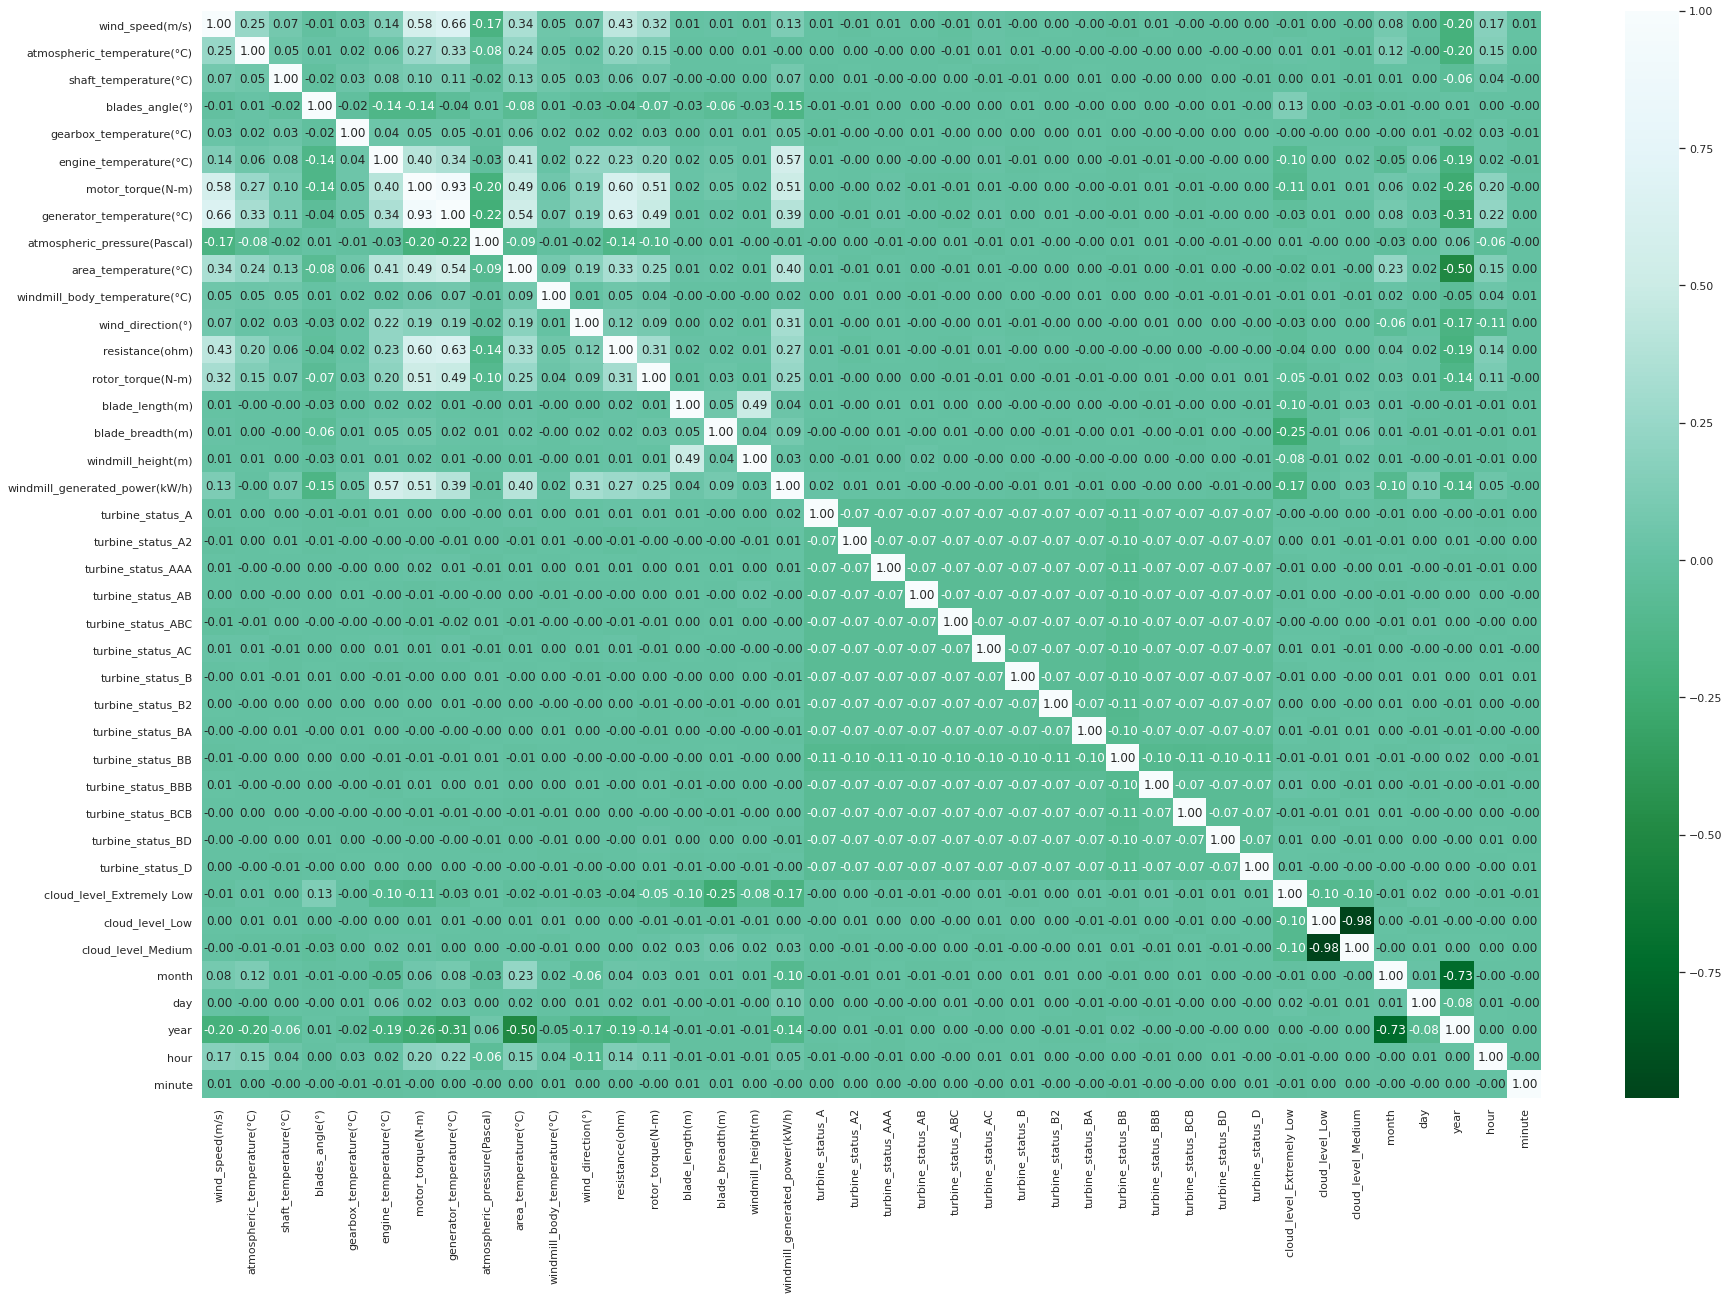

In [ ]:
 plt.figure(figsize=(30,20))
sns.heatmap(data_train.corr(),annot=True,cmap='BuGn_r',fmt='.2f')

In [ ]:
vif = pd.DataFrame()
def calc_vif(X):
 # Calculating VIF
 vif["variables"] = X.columns
 vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
 return(vif)
X =  newDataFrame
calc_vif(X)
vif_high = vif.sort_values(by = 'VIF', ascending=False)
vif_high

,variables,VIF
18,turbine_status_AB,inf
26,turbine_status_BCB,inf
19,turbine_status_ABC,inf
22,turbine_status_B2,inf
17,turbine_status_AAA,inf
16,turbine_status_A2,inf
15,turbine_status_A,inf
23,turbine_status_BA,inf
24,turbine_status_BB,inf
25,turbine_status_BBB,inf


In [ ]:
# 1. Initialize the model algorithm
from sklearn.linear_model import LinearRegression

modelLR = LinearRegression()

# 2. Apply RFE to model (ALL FEATURES AND LABEL)
from sklearn.feature_selection import RFE
selectFeaturesFromRFE = RFE(estimator=modelLR,step=1)

# Fit the data with RFE
selectFeaturesFromRFE.fit(features,label)

# 3. Get Features with High Ranking (1,2,3,4,...) (Get features that has Rank 1. Sometimes Rank 2 is considered)
print(selectFeaturesFromRFE.ranking_)


[ 1  1  9 14 17  1  3 20  1 13 18  1  5  1  8  1  1 15 16 10  1  2  1  1
  6 11  4  1  1  1  1  1  1  7  1 12 19]


 'atmospheric_temperature(°C)','shaft_temperature(°C)', 'engine_temperature(°C)', 'area_temperature(°C)', 'windmill_body_temperature(°C)', 'rotor_torque(N-m)',
'blade_breadth(m)', 'turbine_status_A', 'turbine_status_A2', 'turbine_status_AAA', 'turbine_status_B2', 'turbine_status_BB', 'turbine_status_BCB', 'cloud_level_Extremely Low','cloud_level_Low', 'cloud_level_Medium', 'month',  'year'

In [ ]:
# Initialize the model algorithm
from sklearn.linear_model import LinearRegression
modelLR = LinearRegression()
# 2. Apply SBM to model (ALL FEATURES AND LABEL)
from sklearn.feature_selection import SelectFromModel
selectFeaturesFromSFM = SelectFromModel(modelLR)
# Fit the data with SFM
selectFeaturesFromSFM.fit(features,label)
# 3. Get Features with True value
print(selectFeaturesFromSFM.get_support())


[ True  True False False False  True False False False False False False
 False  True False False False False False False False False False False
 False False False False False  True  True  True False False False False
 False]


'atmospheric_temperature(°C)','engine_temperature(°C)', 'blade_breadth(m)', 'cloud_level_Extremely Low', 'cloud_level_Low', 'cloud_level_Medium', 'year'

### **Feature Engineering - OLS**

In [51]:
# import statsmodels.regression.linear_model as sm
# regressor_OLS = sm.OLS(endog = label, exog = features).fit()
# regressor_OLS.summary()

In [52]:
 featureFinal = ['minute', 'windmill_height(m)', 'shaft_temperature(°C)', 'cloud_level_Extremely Low', 'turbine_status_D', 'turbine_status_B', 'turbine_status_BBB', 'turbine_status_ABC', 'turbine_status_AB', 'turbine_status_AAA', 'turbine_status_BB', 'turbine_status_BCB', 'turbine_status_B2', 'turbine_status_A2', 'turbine_status_A', 'turbine_status_BD', 'turbine_status_AC', 'turbine_status_BA']
# featureFinal.append('turbine_status_BA')
# print(featureFinal)

In [53]:
# features.drop(['turbine_status_BA'], axis=1, inplace=True)
# regressor_OLS = sm.OLS(endog = label, exog = features).fit()
# regressor_OLS.summary()

### **Final feature building**

In [54]:
selectedFeatures = newDataFrame
for column in featureFinal:
  selectedFeatures.drop([column], axis=1, inplace =True)

selectedFeatures.columns

Index(['wind_speed(m/s)', 'atmospheric_temperature(°C)', 'blades_angle(°)',
       'gearbox_temperature(°C)', 'engine_temperature(°C)',
       'generator_temperature(°C)', 'atmospheric_pressure(Pascal)',
       'area_temperature(°C)', 'wind_direction(°)', 'resistance(ohm)',
       'rotor_torque(N-m)', 'blade_length(m)', 'blade_breadth(m)',
       'cloud_level_Low', 'cloud_level_Medium', 'month', 'day', 'year',
       'hour'],
      dtype='object')

In [55]:
newDataFrameTest = data_test.drop(['tracking_id','datetime','motor_torque(N-m)', 'windmill_body_temperature(°C)'], axis=1)
featuresTest = newDataFrameTest
for column in featureFinal:
  featuresTest.drop([column], axis=1, inplace = True)

featuresTest.columns

Index(['wind_speed(m/s)', 'atmospheric_temperature(°C)', 'blades_angle(°)',
       'gearbox_temperature(°C)', 'engine_temperature(°C)',
       'generator_temperature(°C)', 'atmospheric_pressure(Pascal)',
       'area_temperature(°C)', 'wind_direction(°)', 'resistance(ohm)',
       'rotor_torque(N-m)', 'blade_length(m)', 'blade_breadth(m)',
       'cloud_level_Low', 'cloud_level_Medium', 'month', 'day', 'year',
       'hour'],
      dtype='object')

### **APPLYING STANDARD SCALER**

In [ ]:
# #initialize scalar
# standardScaler = StandardScaler()
# selectedFeatures = standardScaler.fit_transform(selectedFeatures)
# features = standardScaler.fit_transform(features)
# featuresTest = standardScaler.fit_transform(featuresTest)

In [56]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
selectedFeatures = scaler.fit_transform(selectedFeatures)
featuresTest = scaler.transform(featuresTest)

### **Applying PCA**

In [ ]:
# from sklearn import decomposition
# pca = decomposition.PCA(n_components=4)
# pca.fit(features)
# features = pca.transform(features)
# featuresTest =  pca.transform(featuresTest)

### **Building the Model**

#### **Train Test Split with Feature Engineered Data**

In [ ]:
# x_train,x_test,y_train,y_test = train_test_split(selectedFeatures,label,train_size=0.8,random_state=15)
# print(x_train.shape,y_train.shape)
# print(x_test.shape,y_test.shape)

#### **Train Test Split with whole data**

##### **Finding optimum no random state**

In [ ]:
for i in range(1,50):
  X_train,X_test,y_train,y_test = train_test_split(selectedFeatures, label, test_size=0.2, random_state = i)
  model1 = RandomForestRegressor()
  model1.fit(X_train,y_train)
  
  train_score = model1.score(X_train,y_train)
  test_score = model1.score(X_test,y_test)
  #if (test_score > 0.95):
  print("Test: {} , Train: {} , RS : {}".format(test_score,train_score,i))



In [78]:
x_train,x_test,y_train,y_test = train_test_split(selectedFeatures,label,train_size=0.8,random_state=0)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(22394, 19) (22394,)
(5599, 19) (5599,)


In [ ]:
def objective(trial): 
  n_estimators = trial.suggest_int('n_estimators', 2, 20)
  max_depth = int(trial.suggest_loguniform('max_depth', 1, 32))

  model1 = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=15)
  return sklearn.model_selection.cross_val_score(model1, selectedFeatures, label, n_jobs=-1, cv=3).mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))

Accuracy: 0.949749465596384


In [ ]:
print("Best hyperparameters: {}".format(trial.params))

Best hyperparameters: {'n_estimators': 17, 'max_depth': 17.421225822844686}


In [ ]:
optuna.visualization.plot_optimization_history(study)

#### **Building model**

In [ ]:
# def ModelTypes():
#   modelType = []
#   modelType.append(('LinearRegression'   , make_pipeline(StandardScaler(), LinearRegression())))
#   modelType.append(('Lasso'  ,make_pipeline(StandardScaler(), Lasso())))
#   modelType.append(('Ridge', make_pipeline(StandardScaler(), Ridge(alpha=1.0))))
#   modelType.append(('ElasticNet'  , make_pipeline(StandardScaler(), ElasticNet())))
#   modelType.append(('KNN'   , make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=2))))
#   modelType.append(('ExtraTreesRegressor', make_pipeline(StandardScaler(), ExtraTreesRegressor(n_jobs=-1, min_samples_leaf=1, max_depth=20, min_samples_split=3, n_estimators=1000))))
#   modelType.append(('DecisionTree'  , make_pipeline(StandardScaler(), DecisionTreeRegressor())))
#   modelType.append(('RandomForest'   , make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators= 19, max_depth= 21.183668300467755, n_jobs=-1))))
#   modelType.append(('XGBRF'  , make_pipeline(StandardScaler(), XGBRFRegressor(n_jobs=-1, silent=True))))
#   modelType.append(('GradientBoostingRegressor', make_pipeline(StandardScaler(), GradientBoostingRegressor(criterion='mse',random_state=2,max_depth=5,n_estimators=500,min_samples_split=2,min_samples_leaf=2))))
#   modelType.append(('XGBRegressor', make_pipeline(StandardScaler(), XGBRegressor(n_estimators=500,max_depth=5,booster='gbtree',n_jobs=-1,learning_rate=0.1,reg_lambda=0.01,reg_alpha=0.3)))) 
  
#   return modelType

In [151]:
def ModelTypes():
  modelType = []
  modelType.append(('LinearRegression', LinearRegression()))
  modelType.append(('Lasso', Lasso()))
  modelType.append(('Ridge', Ridge(alpha=1.0)))
  modelType.append(('ElasticNet', ElasticNet()))
  modelType.append(('KNN', KNeighborsRegressor(n_neighbors=5)))
  modelType.append(('ExtraTreesRegressor', ExtraTreesRegressor(n_jobs=-1, min_samples_leaf=1, max_depth=20, min_samples_split=3, n_estimators=1000)))
  modelType.append(('DecisionTree', DecisionTreeRegressor()))
  modelType.append(('RandomForest', RandomForestRegressor()))
  modelType.append(('XGBRF', XGBRFRegressor(n_jobs=-1, silent=True)))
  modelType.append(('GradientBoostingRegressor', GradientBoostingRegressor(criterion='mse',random_state=2,max_depth=5,n_estimators=500,min_samples_split=2,min_samples_leaf=2)))
  modelType.append(('XGBRegressor', XGBRegressor(n_estimators=500,max_depth=5,booster='gbtree',n_jobs=-1,learning_rate=0.1,reg_lambda=0.01,reg_alpha=0.3))) 
  
  return modelType

In [152]:
def ModelBuilding(X_train, y_train, models):
  num_folds = 10
  scoring = 'neg_mean_squared_error'
  SEED = 42
  modelScoreDict = {}
  for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=SEED)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold)
    modelScoreDict[name] = cv_results
    scores = "{}: {} ({})" .format(name, cv_results.mean(), cv_results.std())
    print(scores)

  return modelScoreDict

In [ ]:
%%time
models = ModelTypes()
modelScoreDict = ModelBuilding(x_train, y_train, models)

In [58]:
gbr = GradientBoostingRegressor(criterion='mse',random_state=2,max_depth=5,n_estimators=500,min_samples_split=2,min_samples_leaf=2)
et = ExtraTreesRegressor(n_jobs=-1, min_samples_leaf=1, max_depth=20, min_samples_split=3, n_estimators=1000)
xgb = XGBRegressor(n_estimators=500,max_depth=5,booster='gbtree',n_jobs=-1,learning_rate=0.1,reg_lambda=0.01,reg_alpha=0.3)
rt = RandomForestRegressor()

In [79]:
%%time

modelFinal = VotingRegressor([('gbr', gbr),('xgb',xgb),('et', et),('rt',rt)],n_jobs=-1)
modelFinal.fit(x_train, y_train)

#y_test_pre = modelFinal.predict(featuresTest)
y_train_pre = modelFinal.predict(x_train)
r2_train = r2_score(y_train, y_train_pre)
rmse_train  = np.sqrt(mean_squared_error(y_train, y_train_pre))
print("-----Training Data Evalution-----")
print("R2 Value: ", r2_train)
print("RMSE: ", rmse_train)

-----Training Data Evalution-----
R2 Value:  0.9937099352750197
RMSE:  0.2124632312681492
CPU times: user 11.7 s, sys: 5.18 s, total: 16.9 s
Wall time: 3min 15s


### **Predicting the Value from Test Data**

In [71]:
predictedValue = modelFinal.predict(featuresTest)

In [72]:
print("The length of the predicted vlue is: {}".format(len(predictedValue)), "\n")
print(predictedValue)

The length of the predicted vlue is: 12086 

[ 2.40084455  2.49569063  3.29165346 ...  5.31340969  5.43316532
 10.44407001]


In [74]:
finalDataFrame = test.loc[:,['tracking_id','datetime']]
finalDataFrame['windmill_generated_power(kW/h)'] = predictedValue 

In [75]:
finalDataFrame

,tracking_id,datetime,windmill_generated_power(kW/h)
0,WM_19817,2019-04-17 08:53:20,2.400845
1,WM_18723,2019-03-30 07:43:20,2.495691
2,WM_34552,2019-08-10 11:33:20,3.291653
3,WM_28570,2019-06-26 03:53:20,6.195153
4,WM_36934,2019-08-27 16:43:20,3.494281
...,...,...,...
12081,WM_13376,2019-02-12 11:33:20,6.430152
12082,WM_1630,2018-11-12 17:33:20,3.353678
12083,WM_24703,2019-05-27 11:53:20,5.313410
12084,WM_22893,2019-05-13 21:53:20,5.433165


In [68]:
finalDataFrame.to_csv('/content/drive/My Drive/HackersEarth/predictionDataNew6.csv', header=True, index=False)